# Paramter Inference with Matter Power Spectra

In [2]:
import sys, os
from matplotlib import pyplot as plt
import numpy as np
import camb

from pyPIPS.datasets import Datapoint, Dataset

In [3]:
def get_matter_ps(params):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=params["H0"], ombh2=params["ombh2"], omch2=params["omch2"], mnu=0.06, omk=0, tau=0.06)
    pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
    
    pars.set_matter_power(redshifts=np.arange(0, 10, 1), kmax=1)
    pars.NonLinear = camb.model.NonLinear_both
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)
    kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-2, maxkh=1, npoints = 10)
    
    return Datapoint(ks=kh_nonlin, zs=z_nonlin, P_kz=pk_nonlin.T, params=params)

Note: redshifts have been re-sorted (earliest first)
(10, 10)


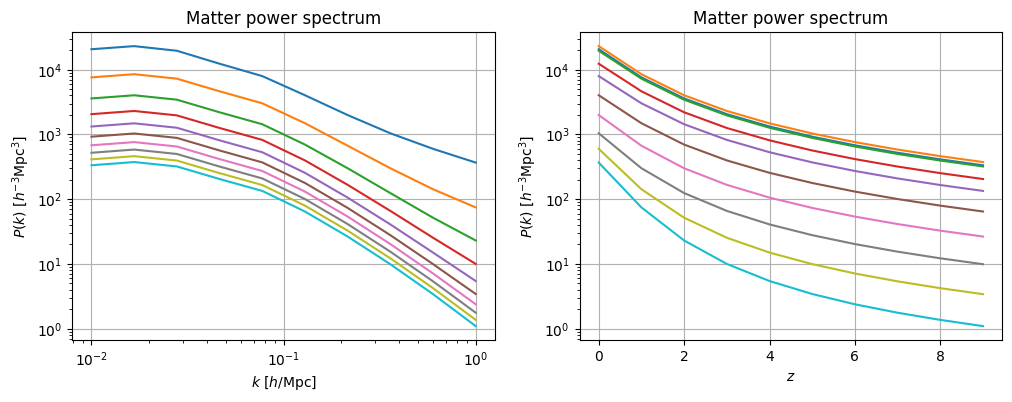

In [4]:
val = get_matter_ps({"H0": 67.5, "ombh2": 0.022, "omch2": 0.122})
print(val.P_kz.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.loglog(val.ks, val.P_kz)
ax1.grid()
ax1.set_xlabel(r"$k$ [$h$/Mpc]")
ax1.set_ylabel(r"$P(k)$ [$h^{-3}$Mpc$^3$]")
ax1.set_title("Matter power spectrum")
ax2.plot(val.zs, val.P_kz.T)
ax2.set_yscale("log")
ax2.grid()
ax2.set_xlabel(r"$z$")
ax2.set_ylabel(r"$P(k)$ [$h^{-3}$Mpc$^3$]")
ax2.set_title("Matter power spectrum")
plt.show()
plt.close()


In [5]:
dataset = Dataset()
dataset.generate_from_func(get_matter_ps, 20, {"H0": [50, 100], "ombh2": [0.01, 0.05], "omch2": [0.01, 0.5]})

0
Note: redshifts have been re-sorted (earliest first)
1
Note: redshifts have been re-sorted (earliest first)
2
Note: redshifts have been re-sorted (earliest first)
3
Note: redshifts have been re-sorted (earliest first)
4
Note: redshifts have been re-sorted (earliest first)
5
Note: redshifts have been re-sorted (earliest first)
6
Note: redshifts have been re-sorted (earliest first)
7
Note: redshifts have been re-sorted (earliest first)
8
Note: redshifts have been re-sorted (earliest first)
9
Note: redshifts have been re-sorted (earliest first)
10
Note: redshifts have been re-sorted (earliest first)
11
Note: redshifts have been re-sorted (earliest first)
12
Note: redshifts have been re-sorted (earliest first)
13
Note: redshifts have been re-sorted (earliest first)
14
Note: redshifts have been re-sorted (earliest first)
15
Note: redshifts have been re-sorted (earliest first)
16
Note: redshifts have been re-sorted (earliest first)
17
Note: redshifts have been re-sorted (earliest first)
18

In [6]:
dataset